In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
class LSTM_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        _, (h, _) = self.encoder(x)  # h: (1, batch, hidden_dim)
        h_repeated = h.repeat(x.size(1), 1, 1).permute(1, 0, 2)  # (batch, seq_len, hidden_dim)
        dec_out, _ = self.decoder(h_repeated)
        out = self.output_layer(dec_out)  # (batch, seq_len, input_dim)
        return out

def compare_summary(df1, df2, cols):
    return pd.DataFrame({
        "Original Mean": df1[cols].mean(),
        "Synthetic Mean": df2[cols].mean(),
        "Original Std": df1[cols].std(),
        "Synthetic Std": df2[cols].std(),
        "Original Skew": df1[cols].skew(),
        "Synthetic Skew": df2[cols].skew(),
        "Original Kurt": df1[cols].kurt(),
        "Synthetic Kurt": df2[cols].kurt()
    })

In [3]:
epochs = 100
seq_len = 730

In [4]:
df = pd.read_csv("energy_data_panel.csv")
# One-hot categoricals (keep all levels to allow reconstruction later)
cat_cols = ['dwelling_type','income_class','region']
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

In [5]:
# Feature set to model (you can add/remove)
base_feats = [
    'kwh','high_usage','temperature','price_index','is_weekend','efficiency',
    'treatment','post'
]
oh_feats = [c for c in df.columns if c.startswith('dwelling_type_') or c.startswith('income_class_') or c.startswith('region_')]
feature_cols = base_feats + oh_feats

for col in feature_cols:
    df[col] = df.groupby('house_id')[col].transform(lambda x: x.fillna(x.mean()))
    df[col] = df[col].fillna(df[col].mean())

# Keep only complete panels
panel = df.groupby("house_id").filter(lambda g: len(g) == seq_len)
panel = panel.sort_values(["house_id", "t"])

# Normalize features
scalers = {col: MinMaxScaler() for col in feature_cols}
for col in feature_cols:
    panel[col] = scalers[col].fit_transform(panel[[col]])

# Reshape into (N, T, D)
households = panel['house_id'].unique()
n_households = len(households)
n_features = len(feature_cols)

X = panel[feature_cols].values.reshape(n_households, seq_len, n_features)
X_tensor = torch.tensor(X, dtype=torch.float32)

In [ ]:
model = LSTM_AE(input_dim=n_features, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

loader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)
model.train()
for epoch in range(epochs):
    losses = []
    for (x_batch,) in loader:
        optimizer.zero_grad()
        x_recon = model(x_batch)
        loss = criterion(x_recon, x_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1} - Loss: {np.mean(losses):.4f}")

# Sample synthetic data
model.eval()
with torch.no_grad():
    synthetic = model(X_tensor).numpy()

# Denormalize + reformat
for i, col in enumerate(feature_cols):
    synthetic[:, :, i] = scalers[col].inverse_transform(synthetic[:, :, i])

syn_df = []
for i, house_id in enumerate(households):
    for t in range(seq_len):
        row = dict(house_id=house_id, t=t, date=pd.Timestamp("2023-01-01") + pd.Timedelta(days=t))
        row.update({col: synthetic[i, t, j] for j, col in enumerate(feature_cols)})
        syn_df.append(row)

synthetic_df = pd.DataFrame(syn_df)

Epoch 1 - Loss: 0.2999
Epoch 2 - Loss: 0.2034
Epoch 3 - Loss: 0.1563
Epoch 4 - Loss: 0.1472
Epoch 5 - Loss: 0.1391
Epoch 6 - Loss: 0.1261
Epoch 7 - Loss: 0.1085
Epoch 8 - Loss: 0.0927
Epoch 9 - Loss: 0.0790
Epoch 10 - Loss: 0.0656
Epoch 11 - Loss: 0.0544
Epoch 12 - Loss: 0.0477
Epoch 13 - Loss: 0.0429
Epoch 14 - Loss: 0.0396
Epoch 15 - Loss: 0.0374
Epoch 16 - Loss: 0.0365
Epoch 17 - Loss: 0.0358
Epoch 18 - Loss: 0.0354
Epoch 19 - Loss: 0.0353
Epoch 20 - Loss: 0.0351
Epoch 21 - Loss: 0.0347
Epoch 22 - Loss: 0.0347
Epoch 23 - Loss: 0.0343
Epoch 24 - Loss: 0.0344
Epoch 25 - Loss: 0.0340
Epoch 26 - Loss: 0.0339
Epoch 27 - Loss: 0.0337
Epoch 28 - Loss: 0.0336
Epoch 29 - Loss: 0.0336
Epoch 30 - Loss: 0.0334
Epoch 31 - Loss: 0.0331
Epoch 32 - Loss: 0.0330
Epoch 33 - Loss: 0.0330
Epoch 34 - Loss: 0.0329
Epoch 35 - Loss: 0.0328
Epoch 36 - Loss: 0.0328
Epoch 37 - Loss: 0.0329
Epoch 38 - Loss: 0.0331
Epoch 39 - Loss: 0.0329
Epoch 40 - Loss: 0.0329
Epoch 41 - Loss: 0.0327
Epoch 42 - Loss: 0.0326
E

### Check the synthetic data

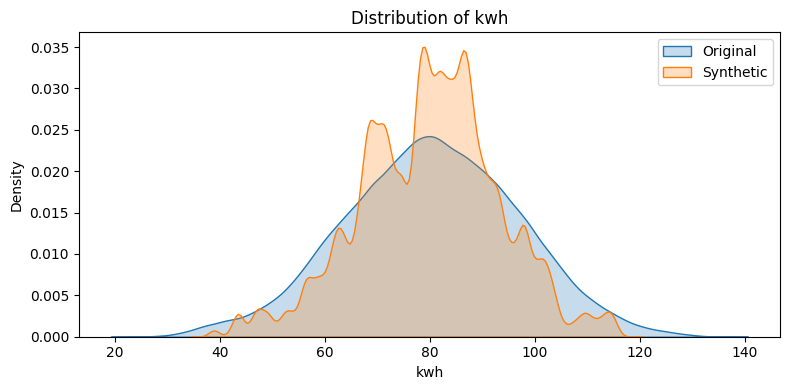

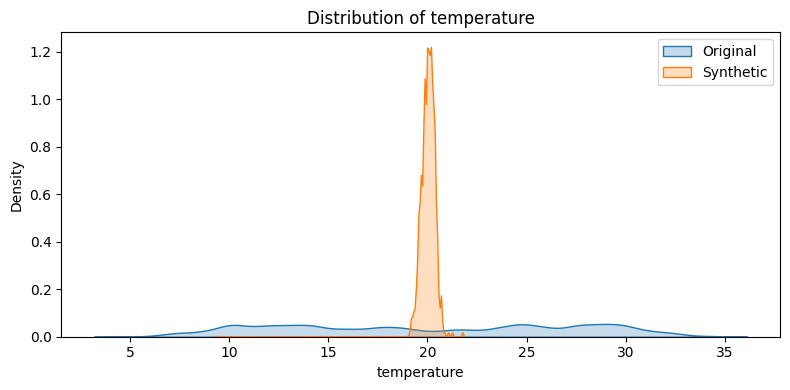

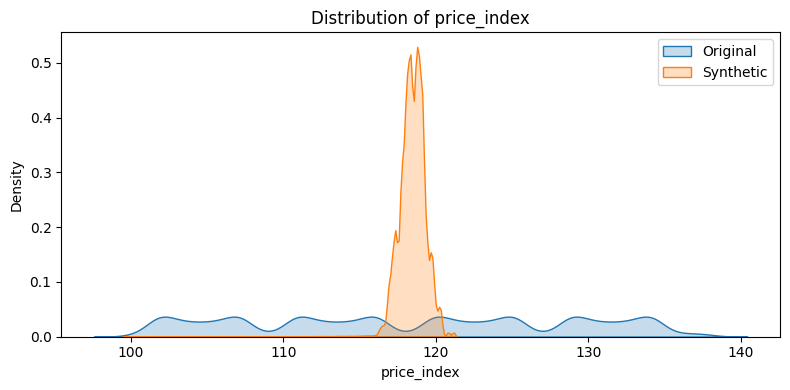

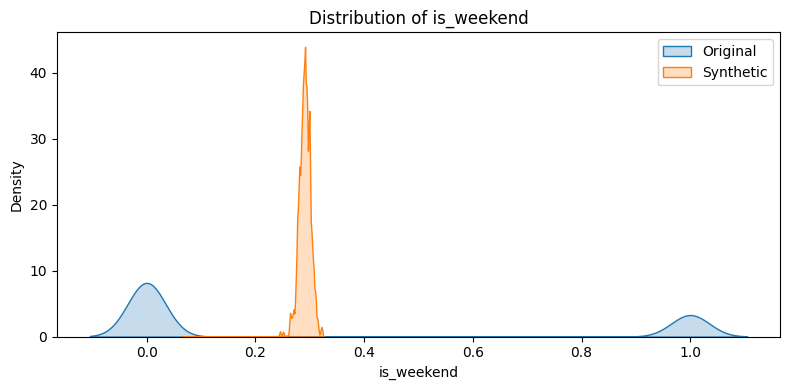

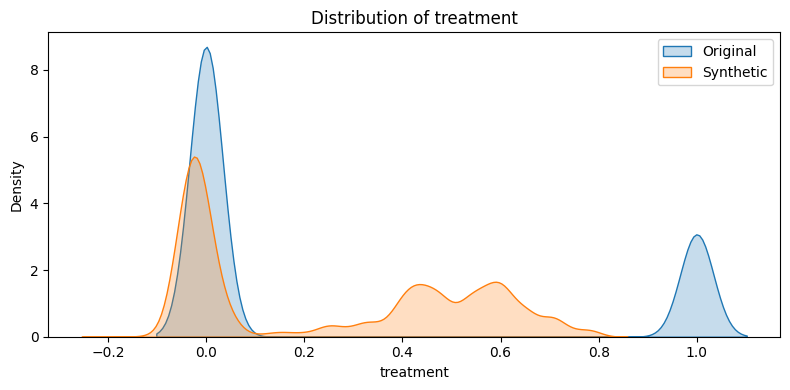

In [7]:
cols_to_plot = ['kwh', 'temperature', 'price_index', 'is_weekend', 'treatment']

for col in cols_to_plot:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df[col], label="Original", fill=True)
    sns.kdeplot(synthetic_df[col], label="Synthetic", fill=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
summary_stats = compare_summary(df, synthetic_df, cols_to_plot)
print(summary_stats)

             Original Mean  Synthetic Mean  Original Std  Synthetic Std  \
kwh              80.301083       79.848732     16.668444      13.386503   
temperature      19.998168       19.995607      7.369127       0.531265   
price_index     118.235661      118.387177     10.469988       1.185348   
is_weekend        0.286301        0.289909      0.452033       0.013484   
treatment         0.261055        0.248935      0.439210       0.280396   

             Original Skew  Synthetic Skew  Original Kurt  Synthetic Kurt  
kwh              -0.061693       -0.148745      -0.132374        0.125264  
temperature      -0.017072       -9.455637      -1.282936      158.256729  
price_index       0.007687       -5.693125      -1.225050       62.308453  
is_weekend        0.945506       -4.364763      -1.106024       49.908340  
treatment         1.088073        0.249631      -0.816101       -1.602380  


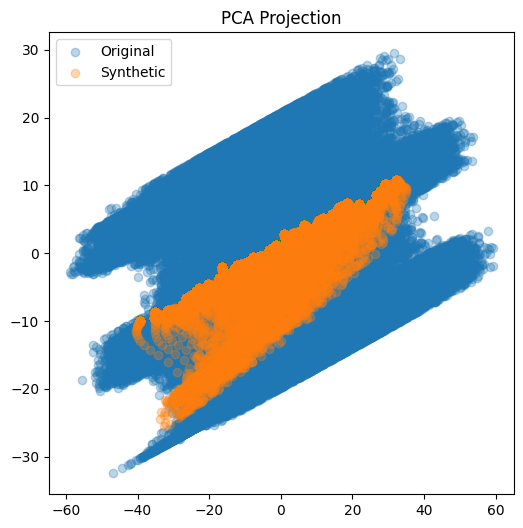

In [9]:
pca = PCA(n_components=2)
original_pca = pca.fit_transform(df[cols_to_plot])
synthetic_pca = pca.transform(synthetic_df[cols_to_plot])

plt.figure(figsize=(6, 6))
plt.scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.3, label="Original")
plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], alpha=0.3, label="Synthetic")
plt.title("PCA Projection")
plt.legend()
plt.show()